## Liver Diseases Prediction

### Data Source

Source: [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/225/ilpd+indian+liver+patient+dataset)

Reference: Ramana,Bendi and Venkateswarlu,N.. (2012). ILPD (Indian Liver Patient Dataset). UCI Machine Learning Repository. https://doi.org/10.24432/C5D02C.

### Import Essential Libraries

In [1]:
# import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

### Load Dataset

In [4]:
# column names of the data
colName = ['Age','Gender','TB','DB','Alkphos','SGPT','SGOT','TP','ALB','A/G_Ratio','Target']

# load the dataset
data = pd.read_csv('../data/Indian_Liver_Patient_Dataset.csv', names=colName)

# check the dimension of the dataset
numrow, numcol = data.shape
print('The dataset contains {} rows and {} columns.'.format(numrow, numcol))

# check the attributes in the dataset
attributes = data.columns
print('Attributes in the dataset:', attributes)

# display the first 5 rows of the dataset
display(data.head(n=5))

The dataset contains 583 rows and 11 columns.
Attributes in the dataset: Index(['Age', 'Gender', 'TB', 'DB', 'Alkphos', 'SGPT', 'SGOT', 'TP', 'ALB',
       'A/G_Ratio', 'Target'],
      dtype='object')


,Age,Gender,TB,DB,Alkphos,SGPT,SGOT,TP,ALB,A/G_Ratio,Target
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


### Attributes Description

1. Age - Age of the patient. Any patient whose age exceeded 89 is listed as being of age "90".
2. Gender - Gender of the patient
3. TB - Total Bilirubin
4. DB - Direct Bilirubin
5. Alkphos - Alkaline Phosphatase
6. SGPT - Alanine Aminotransferase
7. SGOT - Aspartate Aminotransferase
8. TP = Total Proteins
9. ALB - Albumin
10. A/G_Ratio - Albumin and Globulin Ration

In [5]:
# summary of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        583 non-null    int64  
 1   Gender     583 non-null    object 
 2   TB         583 non-null    float64
 3   DB         583 non-null    float64
 4   Alkphos    583 non-null    int64  
 5   SGPT       583 non-null    int64  
 6   SGOT       583 non-null    int64  
 7   TP         583 non-null    float64
 8   ALB        583 non-null    float64
 9   A/G_Ratio  579 non-null    float64
 10  Target     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


In [6]:
# check duplicate records and missing value in each attribute
print('Total number of duplicate records in the dataset:', data.duplicated().sum())
print('Number of missing value in each attributes:')
print(data.isna().sum())

Total number of duplicate records in the dataset: 13
Number of missing value in each attributes:
Age          0
Gender       0
TB           0
DB           0
Alkphos      0
SGPT         0
SGOT         0
TP           0
ALB          0
A/G_Ratio    4
Target       0
dtype: int64


### Data Splitting

In [7]:
# data splitting
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, stratify=data['Target'], shuffle=True, random_state=122)

# check the dimension of the train and test datset
print('Dimension of training data:', train.shape)
print('Dimension of test data:', test.shape)

Dimension of training data: (466, 11)
Dimension of test data: (117, 11)


In [20]:
# segregate the feature matrix and target vector from the training and test dataset
Xtrain = train.drop(columns=['Target'], axis=1)
ytrain = train['Target']

Xtest = test.drop(columns=['Target'], axis=1)
ytest = test['Target']

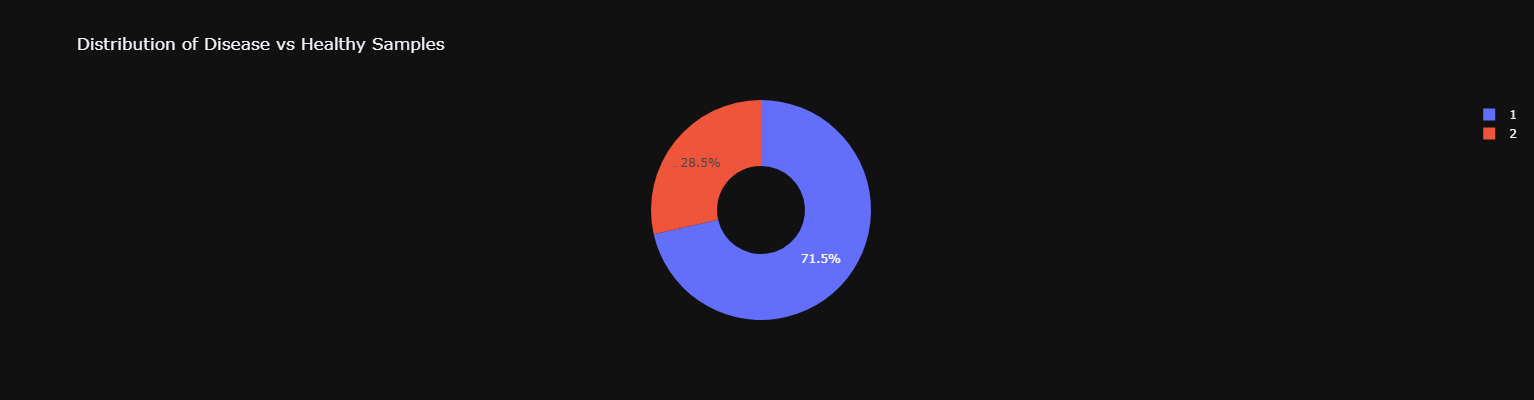

In [21]:
# distribution of the target label 
target = ytrain.value_counts()
target_df = pd.DataFrame(target).reset_index()
target_df.columns = ['Target','Count']

fig = px.pie(target_df, values='Count', names='Target',
             hole=0.4, 
             width=800, height=400, 
             template='plotly_dark', 
             title='Distribution of Disease vs Healthy Samples')
fig.show()

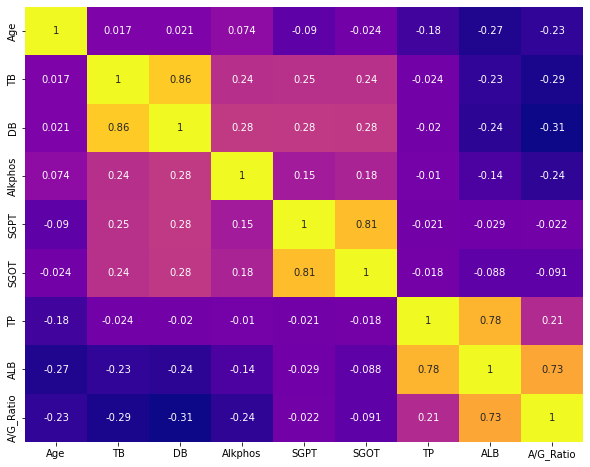

In [30]:
# correlation between numerical variables in the training dataset
num_feats = ['Age', 'TB', 'DB', 'Alkphos', 'SGPT', 'SGOT', 'TP', 'ALB', 'A/G_Ratio']

# compute the corrleation
correlation = Xtrain[num_feats].corr(method='pearson')

# visualize the correlation in heatmap
plt.figure(figsize=(10,8))
heatmap = sns.heatmap(correlation, cmap='plasma', cbar=False, annot=True)
plt.show()

### Data Preprocessing

In [ ]:
# one hot encoding the variable 'Gender'
gender_map = {'Male':1, 'Female':0}
Xtrain['Gender'] = Xtrain['Gender'].map(gender_map)
Xtest['Gender'] = Xtest['Gender'].map(gender_map)

In [52]:
# scale the training and test data
from sklearn.preprocessing import RobustScaler

# instantiate a RobustScaler class
scaler = RobustScaler()

# scaling
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

In [53]:
# impute the missing value in A/G_Ratio
from sklearn.impute import KNNImputer

# instatiate a KNNImputer class
imputer = KNNImputer(n_neighbors=3)

# imputation
Xtrain_imputed = imputer.fit_transform(Xtrain_scaled)
Xtest_imputed = imputer.transform(Xtest_scaled)

# convert the imputed data into dataframe
Xtrain_imp = pd.DataFrame(Xtrain_imputed, columns=Xtrain.columns)
Xtest_imp = pd.DataFrame(Xtest_imputed, columns=Xtest.columns)

In [46]:
# define a helper function to perform model evaluation based on key metrics
from sklearn.metrics import precision_recall_fscore_support, matthews_corrcoef

def performance_evaluation(X,y,clf,classifier_name=''):
    ypred = clf.predict(X)
    accuracy = clf.score(X,y)
    mcc = matthews_corrcoef(y, ypred)
    precision, recall, fscore, support = precision_recall_fscore_support(y, ypred, average='macro', zero_division=0)
    metricName = ['Accuracy','Precision','Recall','F1_Score','MCC']
    metricValue = [accuracy,precision,recall,fscore,mcc]
    res = pd.DataFrame(metricValue, index=metricName, columns=[classifier_name])
    return res

### Model Training

#### Model 1 | Decision Tree

In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# create a Decision Tree Classifier
tree = DecisionTreeClassifier(random_state=122)

# Define the hyperparameter grid
param_grid = {
    'splitter': ['best', 'random'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4]
}

# create the GridSearchCV object
grid_search_tree = GridSearchCV(tree, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# fit the grid search to the data
grid_search_tree.fit(Xtrain_imp, ytrain)

# print the best parameters and the corresponding accuracy
print('Best Parameters: ', grid_search_tree.best_params_)
print('Best AUROC: ', grid_search_tree.best_score_)

# get the best model
best_tree = grid_search_tree.best_estimator_

Best Parameters:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'random'}
Best AUROC:  0.6667616978562252


#### Model 2 | Logistic Regression

In [68]:
from sklearn.linear_model import LogisticRegression

# create a logistic regression Classifier
logreg = LogisticRegression(random_state=122, max_iter=5000)

# define the hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# create the GridSearchCV object
grid_search_logreg = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# fit the grid search to the data
grid_search_logreg.fit(Xtrain_imp, ytrain)

# print the best parameters and the corresponding accuracy
print('Best Parameters: ', grid_search_logreg.best_params_)
print('Best AUROC: ', grid_search_logreg.best_score_)

# get the best model
best_logreg = grid_search_logreg.best_estimator_

Best Parameters:  {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best AUROC:  0.7366583296931555


#### Model 3 | Random Forest

In [70]:
from sklearn.ensemble import RandomForestClassifier

# create a Random Forest Classifier
forest = RandomForestClassifier(random_state=122)

# define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4]
}

# create the GridSearchCV object
grid_search_forest = GridSearchCV(forest, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# fit the grid search to the data
grid_search_forest.fit(Xtrain_imp, ytrain)

# print the best parameters and the corresponding accuracy
print('Best Parameters: ', grid_search_forest.best_params_)
print('Best AUROC: ', grid_search_forest.best_score_)

# get the best model
best_forest = grid_search_forest.best_estimator_

Best Parameters:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best AUROC:  0.744609379932763


#### Model 4 | Support Vector Machine

In [71]:
from sklearn.svm import SVC

# create the SVM classifier
svc = SVC(random_state=122)

# define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100],                 # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],    # Choice of kernel
    'gamma': ['scale', 'auto', 0.1, 1],     # Kernel coefficient for 'rbf' and 'poly'
    'degree': [2, 3, 4]                     # Degree of the polynomial kernel
}

# create a GridSearchCV object with SVM and the parameter grid
grid_search_svc = GridSearchCV(svc, param_grid, cv=5, scoring='roc_auc')

# fit the model with the training data
grid_search_svc.fit(Xtrain_imp, ytrain)

# print the best parameters and the corresponding accuracy
print('Best Parameters: ', grid_search_svc.best_params_)
print('Best AUROC: ', grid_search_svc.best_score_)

# get the best model
best_svc = grid_search_svc.best_estimator_

Best Parameters:  {'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Best AUROC:  0.6983055455692271


In [81]:
# comparing results of different models
lr_res = performance_evaluation(Xtest_imp, ytest, best_logreg, 'Logistic Regression')
tree_res = performance_evaluation(Xtest_imp, ytest, best_tree, 'Decision Tree')
rf_res = performance_evaluation(Xtest_imp, ytest, best_forest, 'Random Forest')
svc_res = performance_evaluation(Xtest_imp, ytest, best_svc, 'Support Vector Machine')

base_res = pd.concat([lr_res, tree_res, rf_res, svc_res], axis=1)
display(base_res)

,Logistic Regression,Decision Tree,Random Forest,Support Vector Machine
Accuracy,0.743590,0.726496,0.692308,0.709402
Precision,0.700069,0.656443,0.585087,0.354701
Recall,0.602232,0.607548,0.548724,0.500000
F1_Score,0.606855,0.614815,0.542174,0.415000
MCC,0.286032,0.259424,0.128776,0.000000


### Imbalanced Classess --- Class Weight Adjustment

#### Model 1 | Decision Tree

In [85]:
# create a Decision Tree Classifier
tree = DecisionTreeClassifier(class_weight='balanced', random_state=122)

# Define the hyperparameter grid
param_grid = {
    'splitter': ['best', 'random'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4]
}

# create the GridSearchCV object
grid_search_tree = GridSearchCV(tree, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# fit the grid search to the data
grid_search_tree.fit(Xtrain_imp, ytrain)

# print the best parameters and the corresponding accuracy
print('Best Parameters: ', grid_search_tree.best_params_)
print('Best AUROC: ', grid_search_tree.best_score_)

# get the best model
balanced_best_tree = grid_search_tree.best_estimator_

Best Parameters:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'best'}
Best AUROC:  0.6907816524731947


#### Model 2 | Logistic Regression

In [86]:
# create a logistic regression Classifier
logreg = LogisticRegression(class_weight='balanced', random_state=122, max_iter=5000)

# define the hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# create the GridSearchCV object
grid_search_logreg = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# fit the grid search to the data
grid_search_logreg.fit(Xtrain_imp, ytrain)

# print the best parameters and the corresponding accuracy
print('Best Parameters: ', grid_search_logreg.best_params_)
print('Best AUROC: ', grid_search_logreg.best_score_)

# get the best model
balanced_best_logreg = grid_search_logreg.best_estimator_

Best Parameters:  {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
Best AUROC:  0.7376416286864048


#### Model 3 | Random Forest

In [87]:
# create a Random Forest Classifier
forest = RandomForestClassifier(class_weight='balanced', random_state=122)

# define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4]
}

# create the GridSearchCV object
grid_search_forest = GridSearchCV(forest, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# fit the grid search to the data
grid_search_forest.fit(Xtrain_imp, ytrain)

# print the best parameters and the corresponding accuracy
print('Best Parameters: ', grid_search_forest.best_params_)
print('Best AUROC: ', grid_search_forest.best_score_)

# get the best model
balanced_best_forest = grid_search_forest.best_estimator_

Best Parameters:  {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best AUROC:  0.751288622930414


#### Model 4 | Support Vector Machine

In [88]:
# create the SVM classifier
svc = SVC(class_weight='balanced', random_state=122)

# define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100],                 # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],    # Choice of kernel
    'gamma': ['scale', 'auto', 0.1, 1],     # Kernel coefficient for 'rbf' and 'poly'
    'degree': [2, 3, 4]                     # Degree of the polynomial kernel
}

# create a GridSearchCV object with SVM and the parameter grid
grid_search_svc = GridSearchCV(svc, param_grid, cv=5, scoring='roc_auc')

# fit the model with the training data
grid_search_svc.fit(Xtrain_imp, ytrain)

# print the best parameters and the corresponding accuracy
print('Best Parameters: ', grid_search_svc.best_params_)
print('Best AUROC: ', grid_search_svc.best_score_)

# get the best model
balanced_best_svc = grid_search_svc.best_estimator_

Best Parameters:  {'C': 1, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
Best AUROC:  0.7473059463109214


In [89]:
# comparing results of different models
lr_res = performance_evaluation(Xtest_imp, ytest, balanced_best_logreg, 'Balanced Logistic Regression')
tree_res = performance_evaluation(Xtest_imp, ytest, balanced_best_tree, 'Balanced Decision Tree')
rf_res = performance_evaluation(Xtest_imp, ytest, balanced_best_forest, 'Balanced Random Forest')
svc_res = performance_evaluation(Xtest_imp, ytest, balanced_best_svc, 'Balanced Support Vector Machine')

balanced_res = pd.concat([lr_res, tree_res, rf_res, svc_res], axis=1)
display(balanced_res)

,Balanced Logistic Regression,Balanced Decision Tree,Balanced Random Forest,Balanced Support Vector Machine
Accuracy,0.743590,0.623932,0.709402,0.555556
Precision,0.728836,0.564123,0.628947,0.697674
Recall,0.775868,0.569986,0.595500,0.686747
F1_Score,0.726806,0.565203,0.600923,0.555263
MCC,0.502508,0.133981,0.221941,0.384266


### Imbalanced Classess --- SMOTE Oversampling Technique

In [75]:
from imblearn.over_sampling import SMOTE

# instantiate a SMOTE class
sm = SMOTE(random_state=122)

# resampling with SMOTE algorithm
Xtrain_resampled, ytrain_resampled = sm.fit_resample(Xtrain_imp, ytrain)

#### Model 1 | Decision Tree

In [90]:
# create a Decision Tree Classifier
tree = DecisionTreeClassifier(random_state=122)

# Define the hyperparameter grid
param_grid = {
    'splitter': ['best', 'random'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4]
}

# create the GridSearchCV object
grid_search_tree = GridSearchCV(tree, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# fit the grid search to the data
grid_search_tree.fit(Xtrain_resampled, ytrain_resampled)

# print the best parameters and the corresponding accuracy
print('Best Parameters: ', grid_search_tree.best_params_)
print('Best AUROC: ', grid_search_tree.best_score_)

# get the best model
resampled_best_tree = grid_search_tree.best_estimator_

Best Parameters:  {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'random'}
Best AUROC:  0.7797569142077941


#### Model 2 | Logistic Regression

In [94]:
# create a logistic regression Classifier
logreg = LogisticRegression(random_state=122, max_iter=5000)

# define the hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# create the GridSearchCV object
grid_search_logreg = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# fit the grid search to the data
grid_search_logreg.fit(Xtrain_resampled, ytrain_resampled)

# print the best parameters and the corresponding accuracy
print('Best Parameters: ', grid_search_logreg.best_params_)
print('Best AUROC: ', grid_search_logreg.best_score_)

# get the best model
resampled_best_logreg = grid_search_logreg.best_estimator_

Best Parameters:  {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best AUROC:  0.7635249802547641


#### Model 3 | Random Forest

In [95]:
# create a Random Forest Classifier
forest = RandomForestClassifier(random_state=122)

# define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4]
}

# create the GridSearchCV object
grid_search_forest = GridSearchCV(forest, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# fit the grid search to the data
grid_search_forest.fit(Xtrain_resampled, ytrain_resampled)

# print the best parameters and the corresponding accuracy
print('Best Parameters: ', grid_search_forest.best_params_)
print('Best AUROC: ', grid_search_forest.best_score_)

# get the best model
resampled_best_forest = grid_search_forest.best_estimator_

Best Parameters:  {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best AUROC:  0.887297569142078


#### Model 4 | Support Vector Machine

In [96]:
# create the SVM classifier
svc = SVC(random_state=122)

# define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100],                 # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],    # Choice of kernel
    'gamma': ['scale', 'auto', 0.1, 1],     # Kernel coefficient for 'rbf' and 'poly'
    'degree': [2, 3, 4]                     # Degree of the polynomial kernel
}

# create a GridSearchCV object with SVM and the parameter grid
grid_search_svc = GridSearchCV(svc, param_grid, cv=5, scoring='roc_auc')

# fit the model with the training data
grid_search_svc.fit(Xtrain_resampled, ytrain_resampled)

# print the best parameters and the corresponding accuracy
print('Best Parameters: ', grid_search_svc.best_params_)
print('Best AUROC: ', grid_search_svc.best_score_)

# get the best model
resampled_best_svc = grid_search_svc.best_estimator_

Best Parameters:  {'C': 10, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}
Best AUROC:  0.9118511918021831


In [98]:
# comparing results of different models
lr_res = performance_evaluation(Xtest_imp, ytest, resampled_best_logreg, 'Resampled Logistic Regression')
tree_res = performance_evaluation(Xtest_imp, ytest, resampled_best_tree, 'Resampled Decision Tree')
rf_res = performance_evaluation(Xtest_imp, ytest, resampled_best_forest, 'Resampled Random Forest')
svc_res = performance_evaluation(Xtest_imp, ytest, resampled_best_svc, 'Resampled Support Vector Machine')

resampled_res = pd.concat([lr_res, tree_res, rf_res, svc_res], axis=1)
display(resampled_res)

,Resampled Logistic Regression,Resampled Decision Tree,Resampled Random Forest,Resampled Support Vector Machine
Accuracy,0.649573,0.666667,0.692308,0.700855
Precision,0.675000,0.625000,0.640097,0.631470
Recall,0.709603,0.643515,0.652906,0.624203
F1_Score,0.641077,0.627358,0.644257,0.627219
MCC,0.383043,0.267876,0.292723,0.255570


### Comparison and Evaluation of Models

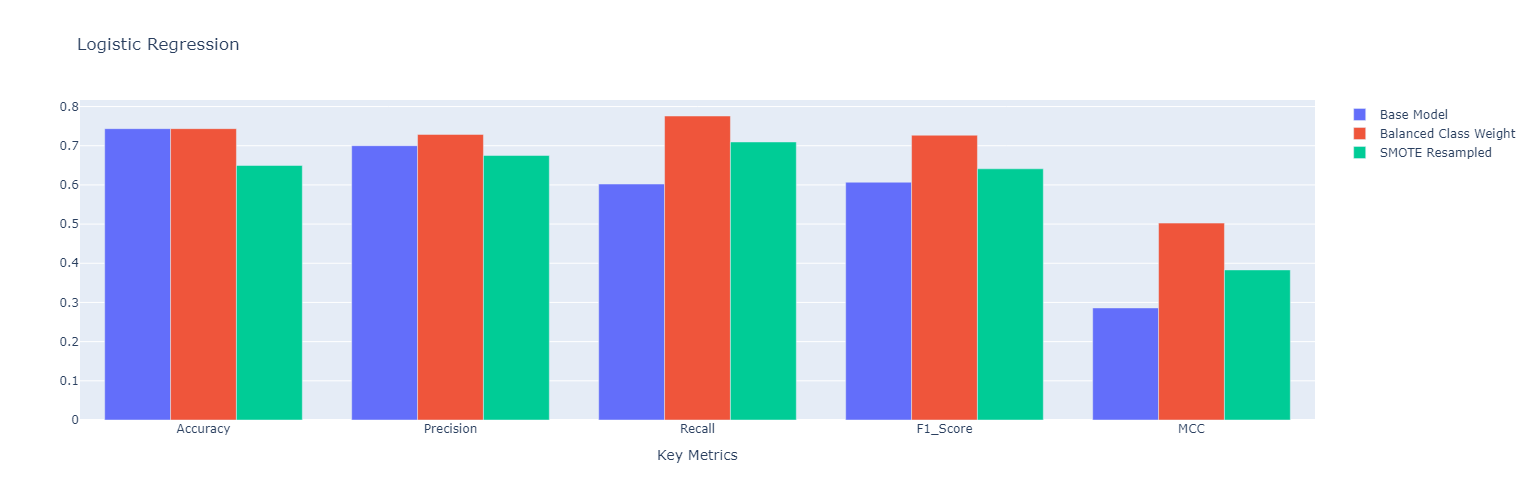

In [117]:
import plotly.graph_objects as go

base = go.Bar(x=base_res.index, y=base_res['Logistic Regression'], name='Base Model')
balanced_classweight = go.Bar(x=balanced_res.index, y=balanced_res['Balanced Logistic Regression'], name='Balanced Class Weight')
resampled = go.Bar(x=resampled_res.index, y=resampled_res['Resampled Logistic Regression'], name='SMOTE Resampled')

fig = go.Figure(data=[base, balanced_classweight, resampled])

fig.update_layout(
    width=1000, height=500,
    title='Logistic Regression',
    xaxis_title='Key Metrics',
    yaxis_title=' ',
    barmode='group'  # change to 'stack' if you want stacked bars
)

fig.show()

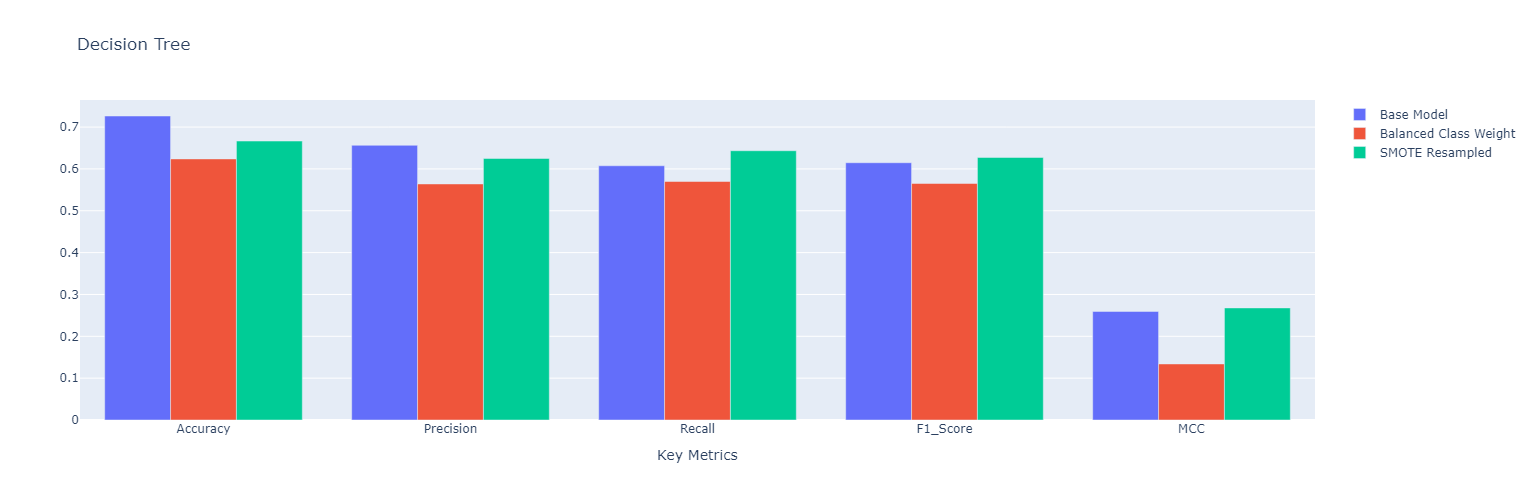

In [120]:
base = go.Bar(x=base_res.index, y=base_res['Decision Tree'], name='Base Model')
balanced_classweight = go.Bar(x=balanced_res.index, y=balanced_res['Balanced Decision Tree'], name='Balanced Class Weight')
resampled = go.Bar(x=resampled_res.index, y=resampled_res['Resampled Decision Tree'], name='SMOTE Resampled')

fig = go.Figure(data=[base, balanced_classweight, resampled])

fig.update_layout(
    width=1000, height=500,
    title='Decision Tree',
    xaxis_title='Key Metrics',
    yaxis_title=' ',
    barmode='group'  
)

fig.show()

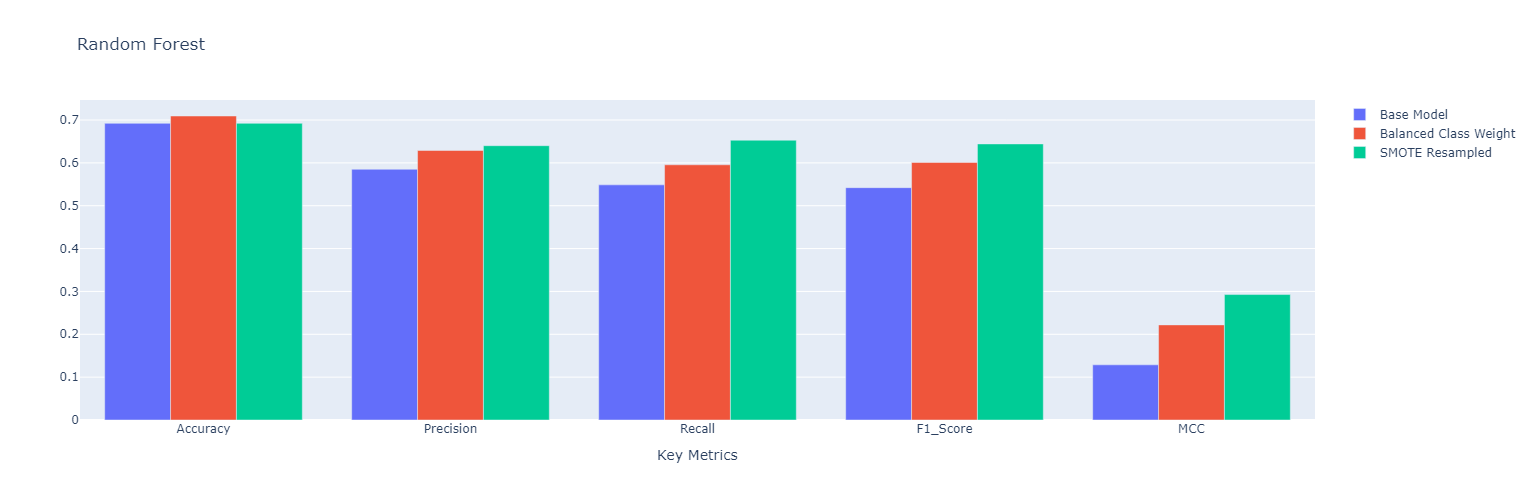

In [119]:
base = go.Bar(x=base_res.index, y=base_res['Random Forest'], name='Base Model')
balanced_classweight = go.Bar(x=balanced_res.index, y=balanced_res['Balanced Random Forest'], name='Balanced Class Weight')
resampled = go.Bar(x=resampled_res.index, y=resampled_res['Resampled Random Forest'], name='SMOTE Resampled')

fig = go.Figure(data=[base, balanced_classweight, resampled])

fig.update_layout(
    width=1000, height=500,
    title='Random Forest',
    xaxis_title='Key Metrics',
    yaxis_title=' ',
    barmode='group' 
)

fig.show()

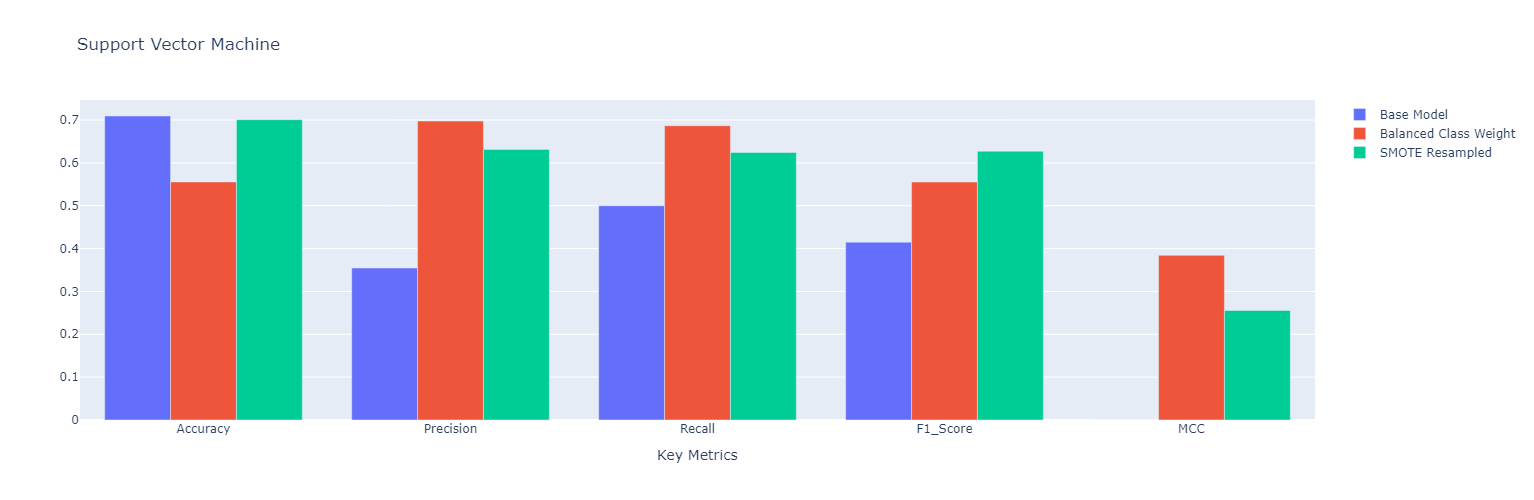

In [121]:
base = go.Bar(x=base_res.index, y=base_res['Support Vector Machine'], name='Base Model')
balanced_classweight = go.Bar(x=balanced_res.index, y=balanced_res['Balanced Support Vector Machine'], name='Balanced Class Weight')
resampled = go.Bar(x=resampled_res.index, y=resampled_res['Resampled Support Vector Machine'], name='SMOTE Resampled')

fig = go.Figure(data=[base, balanced_classweight, resampled])

fig.update_layout(
    width=1000, height=500,
    title='Support Vector Machine',
    xaxis_title='Key Metrics',
    yaxis_title=' ',
    barmode='group' 
)

fig.show()